# Generating image cutouts to assess DELVE-MC dwarf candidates

In [1]:
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io, convolution, wcs
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import name_resolve
from astropy.io import fits
from astropy.utils.data import download_file
from pyvo.dal import sia
from astropy.table import Table
from numpy.core.defchararray import startswith
%matplotlib inline

# Data Lab
from dl import queryClient as qc
from dl.helpers.utils import convert

# set up Simple Image Access (SIA) service
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd_all"
svc = sia.SIAService(DEF_ACCESS_URL)

Copying functions from https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SiaService/How_to_use_the_Simple_Image_Access_service.ipynb

In [2]:
# A little function to download the deepest stacked images
#   adapted from R. Nikutta
def download_deepest_image(ra,dec,svc=sia.SIAService('https://datalab.noirlab.edu/sia'),fov=0.1,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

    sel0 = startswith(imgTable['obs_bandpass'].astype(str),band)
    if any(sel0):
        print("The full image list contains", len(imgTable[sel0]), "entries with bandpass="+band)

        sel = sel0 & ((imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image')) # basic selection
        Table = imgTable[sel] # select
        if (len(Table)>0):
            row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
            url = row['access_url'] # get the download URL
            url = url.replace('http:','https:')
            print ('downloading deepest ' + band + ' image...')
            filename = download_file(url,cache=True,show_progress=True,timeout=120)
            image = fits.getdata(filename)
            hdr = fits.getheader(filename)
            wcs = WCS(hdr)
        else:
            print ('No image available.')
            image=None
            wcs=None
    else:
        print ('No image available.')
        image=None
        wcs=None

        
    return image,wcs,filename

# multi panel image plotter
def plot_images(images,titles=list('gri '),wcs=[None,None,None],cmap=plt.cm.gray_r):
    fig = plt.figure(figsize=(8,10),tight_layout=True)
    grid = plt.GridSpec(4, 3)
    ax1 = fig.add_subplot(grid[0, 0],projection=wcs[0])
    ax2 = fig.add_subplot(grid[0, 1],projection=wcs[1])
    ax3 = fig.add_subplot(grid[0, 2],projection=wcs[2])
    ax4 = fig.add_subplot(grid[1:, 0:],projection=wcs[0])

    for j,ax,img in zip(np.arange(4),[ax1,ax2,ax3,ax4],images):
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=plt.mpl.colors.PowerNorm(0.2))
        #ax.axis('off')
        ax.set_title('{:s}'.format(titles[j]))

# Multi panel image plotter
#def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=matplotlib.cm.gray_r):
#    n = len(images)
#    if geo is None: geo = (n,1)
#        
#    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
#    for j,img in enumerate(images):
#        ax = fig.add_subplot(geo[1],geo[0],j+1)
#        if img is not None:
#            print(img.min(),img.max())
#            vmin = np.median(img)-2*np.std(img)
#            vmax = np.median(img)+2*np.std(img)
#            ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,vmin=vmin, vmax=vmax)
#            ax.set_title('%s band' % bands[j])
#            ax.xaxis.set_visible(False)
#            ax.yaxis.set_visible(False)
            
def get_cutout(row,svc=sia.SIAService("https://datalab.noirlab.edu/sia/coadd_all")):
    band = 'g'
    gimage,gwcs,gfile = download_deepest_image(row['ra'], row['dec'], svc=svc, fov=row['R']*3, band=band) # FOV in deg
    band = 'r'
    rimage,rwcs,rfile = download_deepest_image(row['ra'], row['dec'], svc=svc, fov=row['R']*3, band=band) # FOV in deg
    band = 'i'
    iimage,iwcs,ifile = download_deepest_image(row['ra'], row['dec'], svc=svc, fov=row['R']*3, band=band) # FOV in deg
    
    images = []
    allwcs = []
    files = []
    
    if gimage is not None:
        gimage2 = gimage - np.median(gimage)
        images.append(gimage2)
        allwcs.append(gwcs)
        files.append(gfile)
        
    if rimage is not None:
        rimage2 = rimage - np.median(rimage)
        images.append(rimage2)
        allwcs.append(rwcs)
        files.append(rfile)
        
    if iimage is not None:
        iimage2 = iimage - np.median(iimage)
        images.append(iimage2)
        allwcs.append(iwcs)
        files.append(ifile)
    
    if (len(images) == 3):
        cimage = img = make_lupton_rgb(iimage2, rimage2, gimage2, Q=10, stretch=30)
        images.append(cimage)
    
    return images,allwcs,files

Read in candidate list

In [14]:
t = Table.read('candidate_list.csv')

In [15]:
t

SIG,ra,dec,MODULUS,R,N_OBS,N_OBS_HALF,N_MODEL,MC_SOURCE_ID
float64,float64,float64,float64,float64,int64,int64,float64,int64
17.9447512872043,43.8843477877016,-54.1235166422531,19.0,0.03,66,27,2.278125,0
12.5830708155363,56.0797374062298,-69.4216179870006,18.5,0.01,31,18,0.996875,0
12.2334523826811,0.167796192471199,-61.7638855248805,22.0,0.29,486,160,264.207942166902,0
12.1335045924276,0.169882977539243,-61.7638777471064,22.0,0.29,484,159,264.207942166902,0
10.8442896670378,25.3915583629121,-69.0524619896262,17.5,0.29,987,245,684.889375,0
10.4554973726011,0.699200539977438,-60.8549964789684,18.5,0.13,155,56,58.833125,0
10.3093281847464,0.699839719920956,-60.8505534917239,18.5,0.14,169,60,68.2325,0
10.1423898464486,0.019024781110108,-61.4814044674235,22.5,0.29,518,143,320.63125,0
9.39700119276634,0.011504144426712,-61.3031114221132,23.0,0.17,223,72,110.90375,0


      SIG                ra               dec        MODULUS  R   N_OBS N_OBS_HALF     N_MODEL      MC_SOURCE_ID
---------------- ----------------- ----------------- ------- ---- ----- ---------- ---------------- ------------
12.2334523826811 0.167796192471199 -61.7638855248805    22.0 0.29   486        160 264.207942166902            0
The full image list contains 31 entries with bandpass=g
downloading deepest g image...
The full image list contains 31 entries with bandpass=r
downloading deepest r image...
The full image list contains 18 entries with bandpass=i
downloading deepest i image...


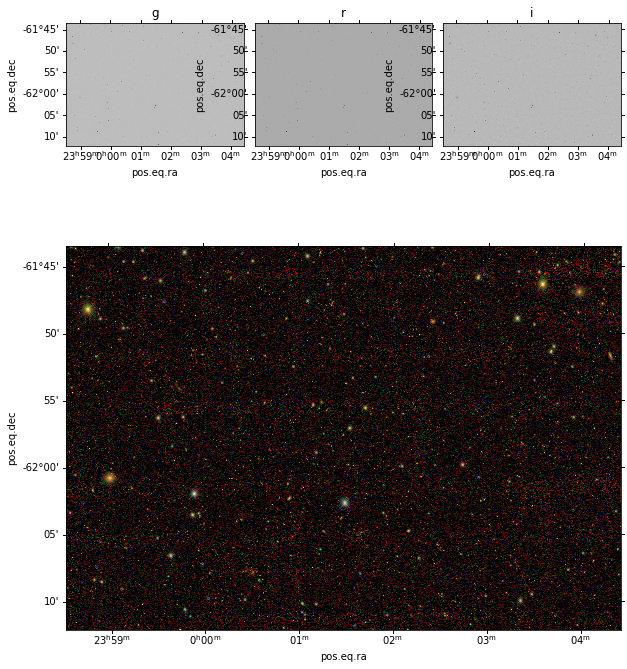

In [17]:
row=t[2]
print(row)
images,wcs,files = get_cutout(row,svc=svc)
plot_images(images, wcs=wcs)

In [18]:
hdu = fits.open(files[0])

In [19]:
files[0]

'/home/js01093/.astropy/cache/download/url/6352329b44cd78d59cbf0a06117646cc/contents'

In [20]:
band = 'g'
gimage,gwcs,gfile = download_deepest_image(row['ra'], row['dec'], svc=svc, fov=row['R']*3, band=band) # FOV in deg
band = 'r'
rimage,rwcs,rfile = download_deepest_image(row['ra'], row['dec'], svc=svc, fov=row['R']*3, band=band) # FOV in deg
band = 'i'
iimage,iwcs,ifile = download_deepest_image(row['ra'], row['dec'], svc=svc, fov=row['R']*3, band=band) # FOV in deg
images=[gimage,rimage,iimage]


The full image list contains 31 entries with bandpass=g
downloading deepest g image...
The full image list contains 31 entries with bandpass=r
downloading deepest r image...
The full image list contains 18 entries with bandpass=i
downloading deepest i image...


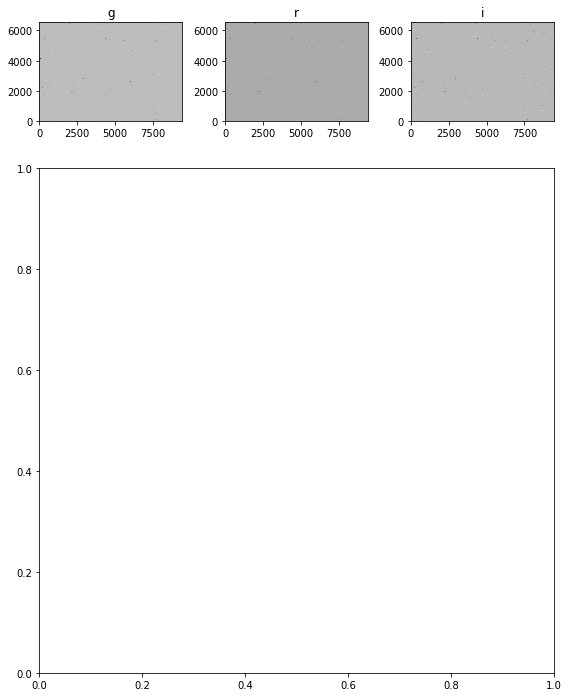

In [21]:
gimage2 = gimage-np.median(gimage)
rimage2 = rimage-np.median(rimage)
iimage2 = iimage-np.median(iimage)
img = make_lupton_rgb(iimage2, rimage2, gimage2, Q=10, stretch=30)
plot_images(images)

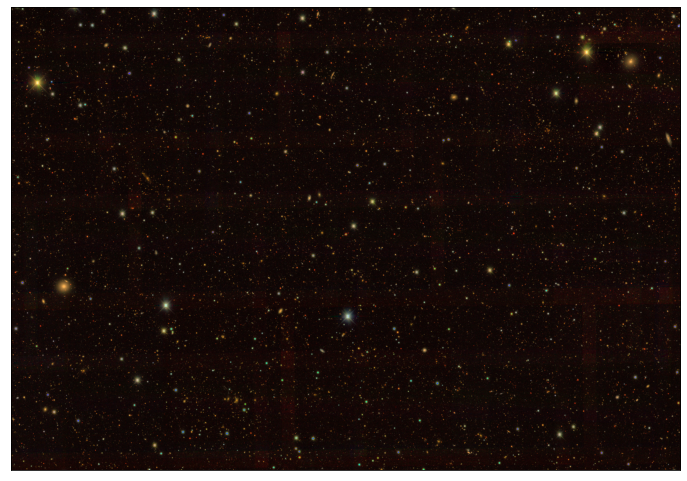

In [22]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(1,1,1)

ax.imshow(img,origin='lower')
ax.scatter(row['ra'], row['dec'], transform=ax.get_transform(), s=row['R'], 
           edgecolor='green', facecolor='none', linewidths=3)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(image, cmap='gray', vmin=image.min(), vmax=image.min()+(image.max()-image.min())/100.)
ax.scatter(df['ra'], df['dec'], transform=ax.get_transform('icrs'), s=1000./(df['gmag']-12), 
           edgecolor='green', facecolor='none', linewidths=3)

TypeError: projection must be a string, None or implement a _as_mpl_axes method, not [WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 0.411953  -62.091667  
CRPIX : 5000.5  1535.5  
CD1_1 CD1_2  : 7.305555555556e-05  0.0  
CD2_1 CD2_2  : -0.0  7.305555555556e-05  
NAXIS : 9436  6535, WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 0.411953  -62.091667  
CRPIX : 5000.5  1535.5  
CD1_1 CD1_2  : 7.305555555556e-05  0.0  
CD2_1 CD2_2  : -0.0  7.305555555556e-05  
NAXIS : 9436  6535, WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 0.411953  -62.091667  
CRPIX : 5000.5  1535.5  
CD1_1 CD1_2  : 7.305555555556e-05  0.0  
CD2_1 CD2_2  : -0.0  7.305555555556e-05  
NAXIS : 9436  6535]

<Figure size 720x720 with 0 Axes>